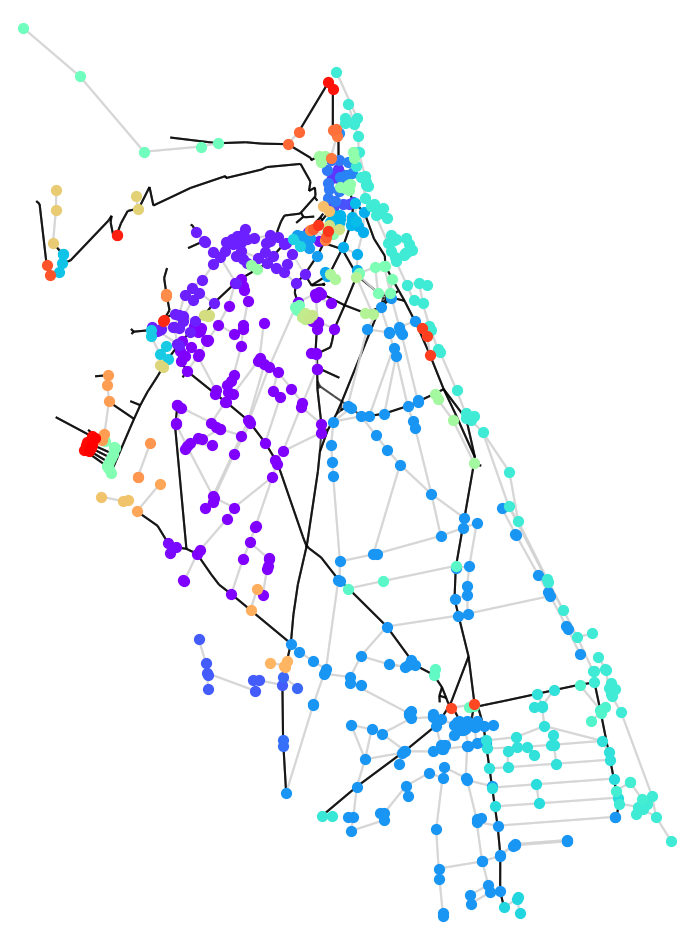

Connected Component 1: {912304642, 912307214, 1875944468, 3445307415, 375694362, 3506974251, 3481947692, 3445307439, 4537840691, 1875944507, 3506974267, 4537840705, 4187438666, 912311372, 3824639566, 4187438672, 3824639579, 4187439196, 4187439199, 1894585954, 375694438, 912302191, 3545182320, 1894585978, 3741330043, 1894585980, 3824639613, 3445307007, 3445307011, 375694984, 912283274, 2143843981, 3824639630, 2143843984, 3824639635, 375694484, 4230598295, 4230598296, 3824639642, 3445307035, 1894586012, 1894586014, 4230598315, 2078574764, 375694512, 3824639672, 912302776, 4230598338, 3783680709, 3680118469, 4230598358, 737610454, 2143871193, 3506974430, 2078574818, 3481946852, 4230598374, 912306922, 3723637997, 3723638012, 912287486, 3506974464, 3506974467, 912305927, 912295190, 3506974487, 912298271, 912306982, 6684814128, 3506974512, 1946089778, 3506974525, 912310593, 1946089796, 3783691600, 2980754259, 3506974548, 3506974552, 6684814180, 1946089828, 912286567, 1946089831, 481334637, 3

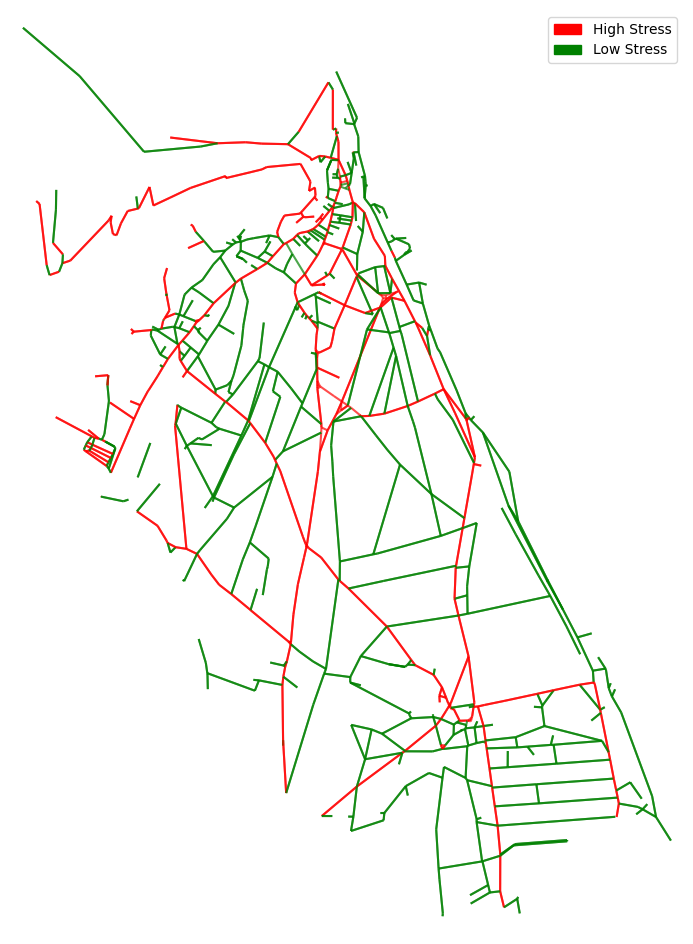

In [29]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import collections
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Montereale_Valcellina_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')

# 1. Filter the Graph
low_stress_edges = [(u, v, k, data) for u, v, k, data in G_lts.edges(keys=True, data=True) if 'lts' in data and data['lts'] in ['1', '2']]
low_stress_nodes = [node for node, data in G_lts.nodes(data=True) if 'lts' in data and data['lts'] in ['1', '2']]

# Create a new graph with only low-stress edges and nodes
G_low_stress = nx.MultiDiGraph()
G_low_stress.add_nodes_from(low_stress_nodes)
G_low_stress.add_edges_from(low_stress_edges)

# 2. Find Connected Components
# Convert the graph to undirected for finding connected components
G_low_stress_undirected = G_low_stress.to_undirected()
connected_components = list(nx.connected_components(G_low_stress_undirected))

# Assign a unique color to each connected component
colors = cm.rainbow(np.linspace(0, 1, len(connected_components)))
component_colors = {}
for color, component in zip(colors, connected_components):
    for node in component:
        component_colors[node] = color

# Visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Get node positions using osmnx
node_positions = {node: (data['x'], data['y']) for node, data in G_lts.nodes(data=True)}

# Plot edges with their respective colors
edge_colors = ['black' if ('lts' in data and data['lts'] in ['3', '4']) else 'lightgray' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=edge_colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Highlight connected components with unique colors
for node, color in component_colors.items():
    nx.draw_networkx_nodes(G_lts, pos=node_positions, nodelist=[node], node_color=[color], node_size=50, ax=ax)

plt.show()

# 3. Identify Gaps
# For simplicity, we'll just print the gaps between connected components
for i, component in enumerate(connected_components):
    print(f"Connected Component {i+1}: {component}")

# Optionally, visualize the graph
fig, ax = plt.subplots(figsize=(12, 12))
colors = ['red' if ('lts' in data and data['lts'] in ['3', '4']) else 'green' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
ax.legend(handles=[red_patch, green_patch], loc='upper right')

plt.show()

In [30]:
## IDCP procedure 

# 1. Identify Contact Nodes
contact_nodes = []
for node, data in G_lts.nodes(data=True):
    adjacent_edges = list(G_lts.out_edges(node, data=True))
    lts_values = [data['lts'] for _, _, data in adjacent_edges]
    if ('1' in lts_values or '2' in lts_values) and ('3' in lts_values or '4' in lts_values):
        contact_nodes.append(node)

# 2. Identify High-Stress Paths using Dijkstra all-pair shortest path algorithm
high_stress_paths = {}
for source in contact_nodes:
    lengths, paths = nx.single_source_dijkstra(G_lts, source, weight='length')
    for target, path in paths.items():
        if target in contact_nodes and source != target:
            lts_values = [G_lts[path[i]][path[i+1]][0]['lts'] for i in range(len(path)-1)]
            if all(lts in ['3', '4'] for lts in lts_values):
                high_stress_paths[(source, target)] = path

# 3. Filter Shortest High-Stress Paths
shortest_high_stress_paths = {}
for (source, target), path in high_stress_paths.items():
    if (target, source) not in shortest_high_stress_paths:
        if (target, source) in high_stress_paths:
            if len(path) < len(high_stress_paths[(target, source)]):
                shortest_high_stress_paths[(source, target)] = path
        else:
            shortest_high_stress_paths[(source, target)] = path

# Print the shortest high-stress paths
# for (source, target), path in shortest_high_stress_paths.items():
#     print(f"Gap from {source} to {target}: {path}")

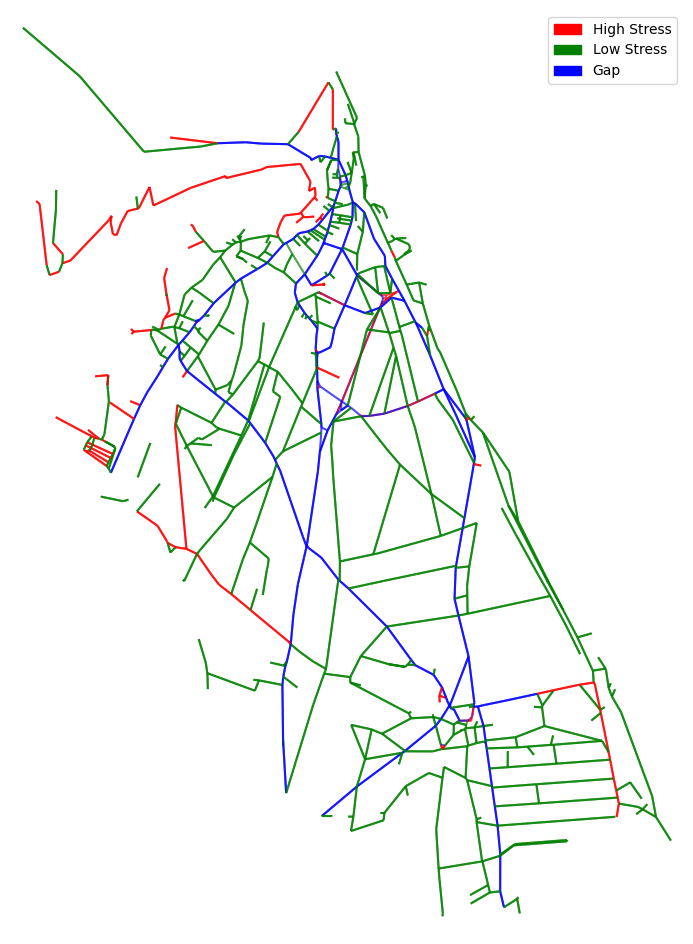

In [31]:
# Create a list of edge colors for the entire graph
edge_colors = []
for u, v, k, data in G_lts.edges(keys=True, data=True):
    if 'lts' in data:
        if data['lts'] in ['1', '2']:
            edge_colors.append('green')
        elif data['lts'] in ['3', '4']:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')
    else:
        edge_colors.append('gray')

# Highlight the gaps in blue
all_edges = list(G_lts.edges(keys=True))
for (source, target), path in shortest_high_stress_paths.items():
    for i in range(len(path) - 1):
        edge_tuple = (path[i], path[i+1], 0)
        edge_index = all_edges.index(edge_tuple)
        edge_colors[edge_index] = 'blue'

# Plot the graph with highlighted gaps
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=edge_colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
blue_patch = mpatches.Patch(color='blue', label='Gap')
ax.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right')

plt.show()


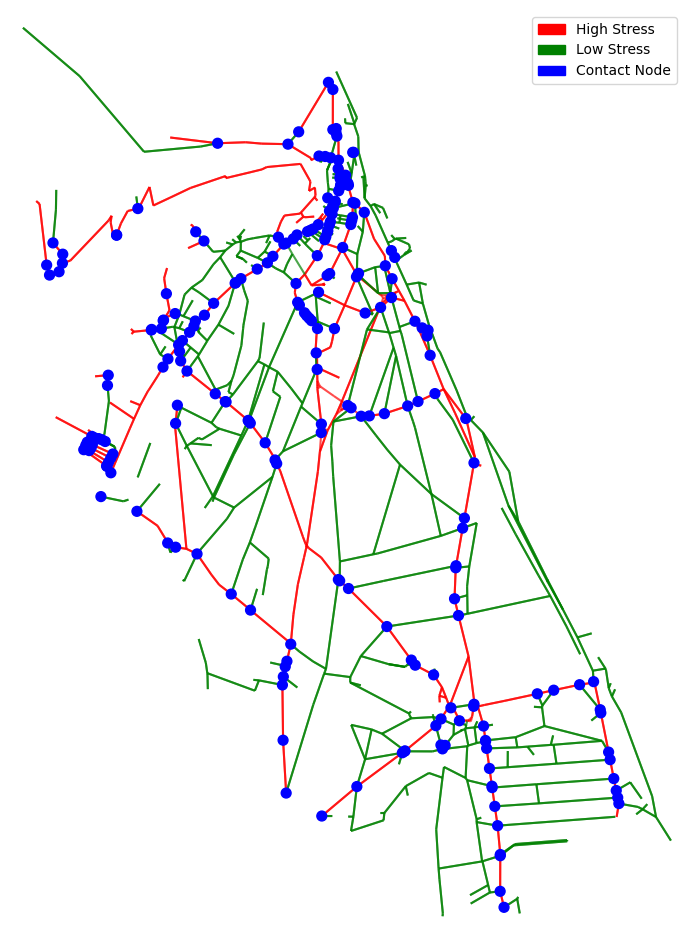

In [32]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Get node positions using osmnx
node_positions = {node: (data['x'], data['y']) for node, data in G_lts.nodes(data=True)}

# Plot edges with their respective colors
colors = ['red' if ('lts' in data and data['lts'] in ['3', '4']) else 'green' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Highlight contact nodes
contact_node_colors = {node: 'blue' for node in contact_nodes}
nx.draw_networkx_nodes(G_lts, pos=node_positions, nodelist=contact_node_colors.keys(), node_color=list(contact_node_colors.values()), node_size=50, ax=ax)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
blue_patch = mpatches.Patch(color='blue', label='Contact Node')
ax.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right')

plt.show()